**DS 6050 Real Estate Imaging Classification Project Notebook**

**Team: Abhijeet Chawhan, Ahmed Soliman, Matt Litz, Karan Manwani**

In [4]:
#Load Packages
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [2]:
from keras.utils import np_utils

from keras.preprocessing import image
from tqdm import tqdm # progress bar


In [3]:
#check directory you are working on
import os
cwd = os.getcwd()
cwd

'/sfs/qumulo/qhome/akp4he/ds6050'

**Data Preprocessing**

In [4]:
#for data_dir use directory (from  above) of where files were unzipped
data_dir = "/sfs/qumulo/qhome/akp4he/ds6050/House_Room_Dataset"

batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 150; 
img_width = 150;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size,
    label_mode='categorical'
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode='categorical'
)        

Found 5250 files belonging to 5 classes.
Using 4200 files for training.


2022-12-06 19:26:21.091299: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-06 19:26:21.091345: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (udc-aw34-12c1): /proc/driver/nvidia/version does not exist
2022-12-06 19:26:21.097016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 5250 files belonging to 5 classes.
Using 1050 files for validation.


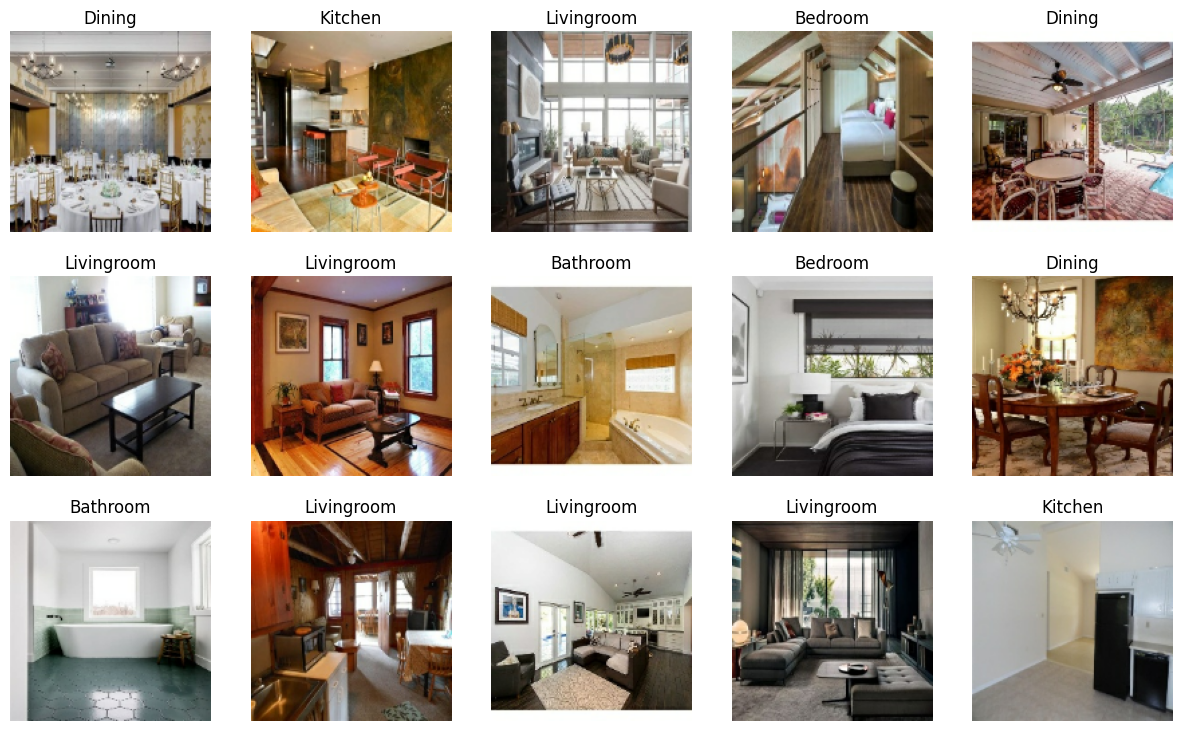

In [5]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['Bathroom','Bedroom','Dining','Kitchen','Livingroom']

# Rows and columns are set to fit one training batch (32)
n_rows = 3
n_cols = 5
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[np.argmax(labels[i])], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


In [15]:

from pathlib import Path
file_path =data_dir
dirs={}
for fn in Path(file_path).glob('**/*'):
    if fn.is_file():
        key=(str(fn.parent).split('/')[7])
        dirs[key]=dirs.get(key, 0)+1
print(dirs)



{'Livingroom': 1273, 'Kitchen': 965, 'Bedroom': 1248, 'Dinning': 1158, 'Bathroom': 606}


**Exploratory Data Analysis**

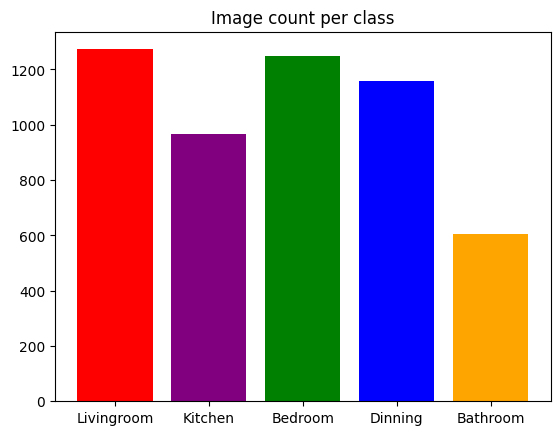

In [18]:
names = list(dirs.keys())
values = list(dirs.values())
c = ['red', 'purple', 'green', 'blue', 'orange']
plt.bar(range(len(dirs)), values, tick_label=names, color= c)
plt.title('Image count per class')
plt.show()

**Preliminary Experiments with Pre Trained Models**

Efficient Net B0, average pooling, batch normalization, hidden layer with 400 nodes and Relu activation, and Adam optimizer

In [61]:
base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet")
avg=keras.layers.GlobalAvgPool2D()(base_model.output)
norm=keras.layers.BatchNormalization()(avg)
relu=keras.layers.Dense(400,activation="relu")(norm)
norm2=keras.layers.BatchNormalization()(relu)
output=keras.layers.Dense(5,activation="softmax")(norm2)
model=keras.Model(inputs=base_model.input,outputs=output)

for layer in base_model.layers:
  layer.trainable=False

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy",tfa.metrics.F1Score(num_classes= 5)])
history = model.fit(train_ds, epochs=20,batch_size=batch_size,validation_data=validation_ds)

Epoch 1/20
132/132 [==============================] - 33s 211ms/step - loss: 0.9739 - accuracy: 0.6429 - f1_score: 0.6420 - val_loss: 0.7560 - val_accuracy: 0.7505 - val_f1_score: 0.7545
Epoch 2/20
132/132 [==============================] - 27s 203ms/step - loss: 0.5860 - accuracy: 0.7886 - f1_score: 0.7916 - val_loss: 0.6338 - val_accuracy: 0.7648 - val_f1_score: 0.7669
Epoch 3/20
132/132 [==============================] - 27s 202ms/step - loss: 0.4859 - accuracy: 0.8248 - f1_score: 0.8296 - val_loss: 0.6147 - val_accuracy: 0.7752 - val_f1_score: 0.7780
Epoch 4/20
132/132 [==============================] - 27s 203ms/step - loss: 0.3926 - accuracy: 0.8579 - f1_score: 0.8610 - val_loss: 0.6079 - val_accuracy: 0.7838 - val_f1_score: 0.7906
Epoch 5/20
132/132 [==============================] - 27s 201ms/step - loss: 0.3440 - accuracy: 0.8764 - f1_score: 0.8796 - val_loss: 0.6016 - val_accuracy: 0.7876 - val_f1_score: 0.7958
Epoch 6/20
132/132 [==============================] - 27s 201ms/s

In [62]:
model.evaluate(validation_ds)

33/33 [==============================] - 5s 155ms/step - loss: 0.6373 - accuracy: 0.8019 - f1_score: 0.8088


[0.6373001933097839,
 0.8019047379493713,
 array([0.84816754, 0.83435583, 0.8141963 , 0.8160377 , 0.7311412 ],
       dtype=float32)]

Efficient Net B0, average pooling, batch normalization, hidden layer with 400 nodes and Relu activation, and Adam optimizer. 100 Epochs

In [64]:
base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet")
avg=keras.layers.GlobalAvgPool2D()(base_model.output)
norm=keras.layers.BatchNormalization()(avg)
relu=keras.layers.Dense(400,activation="relu")(norm)
norm2=keras.layers.BatchNormalization()(relu)
output=keras.layers.Dense(5,activation="softmax")(norm2)
model=keras.Model(inputs=base_model.input,outputs=output)

for layer in base_model.layers:
  layer.trainable=False

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss="categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy",tfa.metrics.F1Score(num_classes= 5)])
history = model.fit(train_ds, epochs=100,batch_size=batch_size,validation_data=validation_ds)

Epoch 1/100
132/132 [==============================] - 32s 207ms/step - loss: 1.0156 - accuracy: 0.6317 - f1_score: 0.6313 - val_loss: 0.7566 - val_accuracy: 0.7486 - val_f1_score: 0.7539
Epoch 2/100
132/132 [==============================] - 26s 199ms/step - loss: 0.5772 - accuracy: 0.7864 - f1_score: 0.7879 - val_loss: 0.5910 - val_accuracy: 0.7819 - val_f1_score: 0.7849
Epoch 3/100
132/132 [==============================] - 26s 200ms/step - loss: 0.4760 - accuracy: 0.8248 - f1_score: 0.8279 - val_loss: 0.5691 - val_accuracy: 0.7895 - val_f1_score: 0.7958
Epoch 4/100
132/132 [==============================] - 26s 199ms/step - loss: 0.3835 - accuracy: 0.8614 - f1_score: 0.8648 - val_loss: 0.5700 - val_accuracy: 0.7914 - val_f1_score: 0.7981
Epoch 5/100
132/132 [==============================] - 27s 201ms/step - loss: 0.3406 - accuracy: 0.8760 - f1_score: 0.8781 - val_loss: 0.5650 - val_accuracy: 0.8000 - val_f1_score: 0.8022
Epoch 6/100
132/132 [==============================] - 27s 2

In [65]:
model.evaluate(validation_ds)

33/33 [==============================] - 5s 156ms/step - loss: 0.7264 - accuracy: 0.8152 - f1_score: 0.8205


[0.7264193892478943,
 0.8152381181716919,
 array([0.8494624 , 0.8482328 , 0.8131417 , 0.82464457, 0.76717556],
       dtype=float32)]

Efficient Net V2L, average pooling, batch normalization, hidden layer with 400 nodes and Relu activation, and Adam optimizer

In [8]:
base_model=keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False, weights="imagenet")
avg=keras.layers.GlobalAvgPool2D()(base_model.output)
norm=keras.layers.BatchNormalization()(avg)
relu=keras.layers.Dense(400,activation="ReLU")(norm)
norm2=keras.layers.BatchNormalization()(relu)
output=keras.layers.Dense(5,activation="softmax")(norm2)
model=keras.Model(inputs=base_model.input,outputs=output)

for layer in base_model.layers:
  layer.trainable=False

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy",tfa.metrics.F1Score(num_classes= 5)])
history = model.fit(train_ds, epochs=10,batch_size=batch_size,validation_data=validation_ds)

Epoch 1/10
132/132 [==============================] - 201s 1s/step - loss: 0.9310 - accuracy: 0.7100 - f1_score: 0.7131 - val_loss: 0.7693 - val_accuracy: 0.7181 - val_f1_score: 0.7369
Epoch 2/10
132/132 [==============================] - 177s 1s/step - loss: 0.5331 - accuracy: 0.8060 - f1_score: 0.8118 - val_loss: 0.5944 - val_accuracy: 0.7800 - val_f1_score: 0.7925
Epoch 3/10
132/132 [==============================] - 177s 1s/step - loss: 0.4301 - accuracy: 0.8307 - f1_score: 0.8390 - val_loss: 0.5560 - val_accuracy: 0.7905 - val_f1_score: 0.7973
Epoch 4/10
132/132 [==============================] - 178s 1s/step - loss: 0.3667 - accuracy: 0.8645 - f1_score: 0.8698 - val_loss: 0.5565 - val_accuracy: 0.8114 - val_f1_score: 0.8199
Epoch 5/10
132/132 [==============================] - 178s 1s/step - loss: 0.3376 - accuracy: 0.8736 - f1_score: 0.8785 - val_loss: 0.6018 - val_accuracy: 0.7943 - val_f1_score: 0.8042
Epoch 6/10
132/132 [==============================] - 177s 1s/step - loss: 

In [9]:
model.evaluate(validation_ds)

33/33 [==============================] - 34s 1s/step - loss: 0.6482 - accuracy: 0.7952 - f1_score: 0.8004


[0.6482419371604919,
 0.7952380776405334,
 array([0.84210527, 0.8385744 , 0.7951807 , 0.7688312 , 0.7570622 ],
       dtype=float32)]

InceptionResNetV2, average pooling, batch normalization, hidden layer with 400 nodes and Relu activation, and Adam optimizer

In [11]:
base_model=keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights="imagenet")
avg=keras.layers.GlobalAvgPool2D()(base_model.output)
norm=keras.layers.BatchNormalization()(avg)
relu=keras.layers.Dense(400,activation="relu")(norm)
norm2=keras.layers.BatchNormalization()(relu)
output=keras.layers.Dense(5,activation="softmax")(norm2)
model=keras.Model(inputs=base_model.input,outputs=output)

for layer in base_model.layers:
  layer.trainable=False

optimizer=tf.keras.optimizers.SGD(learning_rate=0.2,momentum=0.9,decay=0.01)
model.compile(loss="categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy",tfa.metrics.F1Score(num_classes= 5)])
history = model.fit(train_ds, epochs=10,batch_size=batch_size,validation_data=validation_ds)

Epoch 1/10
132/132 [==============================] - 65s 433ms/step - loss: 3.0506 - accuracy: 0.2488 - f1_score: 0.2396 - val_loss: 1.6796 - val_accuracy: 0.2295 - val_f1_score: 0.1483
Epoch 2/10
132/132 [==============================] - 54s 411ms/step - loss: 1.5272 - accuracy: 0.2824 - f1_score: 0.2776 - val_loss: 1.5403 - val_accuracy: 0.2714 - val_f1_score: 0.2437
Epoch 3/10
132/132 [==============================] - 55s 414ms/step - loss: 1.5109 - accuracy: 0.2960 - f1_score: 0.2958 - val_loss: 1.5272 - val_accuracy: 0.2895 - val_f1_score: 0.2779
Epoch 4/10
132/132 [==============================] - 54s 413ms/step - loss: 1.5056 - accuracy: 0.3055 - f1_score: 0.3044 - val_loss: 1.5352 - val_accuracy: 0.2733 - val_f1_score: 0.2442
Epoch 5/10
132/132 [==============================] - 54s 411ms/step - loss: 1.4987 - accuracy: 0.2993 - f1_score: 0.2997 - val_loss: 1.5257 - val_accuracy: 0.2829 - val_f1_score: 0.2778
Epoch 6/10
132/132 [==============================] - 55s 414ms/s

In [12]:
model.evaluate(validation_ds)

33/33 [==============================] - 11s 326ms/step - loss: 1.5184 - accuracy: 0.3010 - f1_score: 0.2948


[1.5183560848236084,
 0.30095237493515015,
 array([0.2885572 , 0.30443975, 0.30927834, 0.24      , 0.3316413 ],
       dtype=float32)]

Efficient Net V2M, average pooling, batch normalization, hidden layers with 400,200,100, and 50 nodes and Relu activation, and Adam optimizer

In [13]:
base_model=keras.applications.EfficientNetV2M(include_top=False, weights="imagenet")
avg=keras.layers.GlobalAvgPool2D()(base_model.output)
norm=keras.layers.BatchNormalization()(avg)
relu=keras.layers.Dense(400,activation="relu")(norm)
norm2=keras.layers.BatchNormalization()(relu)
relu=keras.layers.Dense(200,activation="relu")(norm2)
norm2=keras.layers.BatchNormalization()(relu)
relu=keras.layers.Dense(100,activation="relu")(norm2)
norm2=keras.layers.BatchNormalization()(relu)
relu=keras.layers.Dense(50,activation="relu")(norm2)
norm2=keras.layers.BatchNormalization()(relu)
output=keras.layers.Dense(5,activation="softmax")(norm2)
model=keras.Model(inputs=base_model.input,outputs=output)

for layer in base_model.layers:
  layer.trainable=False

optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy",tfa.metrics.F1Score(num_classes= 5)])
history = model.fit(train_ds, epochs=10,batch_size=batch_size,validation_data=validation_ds)

Epoch 1/10
132/132 [==============================] - 117s 776ms/step - loss: 0.9241 - accuracy: 0.6510 - f1_score: 0.6526 - val_loss: 0.9208 - val_accuracy: 0.6848 - val_f1_score: 0.6841
Epoch 2/10
132/132 [==============================] - 98s 744ms/step - loss: 0.6730 - accuracy: 0.7460 - f1_score: 0.7499 - val_loss: 0.7358 - val_accuracy: 0.7190 - val_f1_score: 0.7288
Epoch 3/10
132/132 [==============================] - 98s 745ms/step - loss: 0.5925 - accuracy: 0.7764 - f1_score: 0.7799 - val_loss: 0.7012 - val_accuracy: 0.7362 - val_f1_score: 0.7457
Epoch 4/10
132/132 [==============================] - 99s 749ms/step - loss: 0.5415 - accuracy: 0.7860 - f1_score: 0.7898 - val_loss: 0.7183 - val_accuracy: 0.7429 - val_f1_score: 0.7467
Epoch 5/10
132/132 [==============================] - 99s 750ms/step - loss: 0.4866 - accuracy: 0.8169 - f1_score: 0.8201 - val_loss: 0.7254 - val_accuracy: 0.7514 - val_f1_score: 0.7606
Epoch 6/10
132/132 [==============================] - 99s 747ms/

In [14]:
model.evaluate(validation_ds)

33/33 [==============================] - 19s 577ms/step - loss: 0.7844 - accuracy: 0.7505 - f1_score: 0.7556


[0.7843798995018005,
 0.7504761815071106,
 array([0.7916667 , 0.804829  , 0.75107294, 0.73659676, 0.6937985 ],
       dtype=float32)]

**Final Classification Model**

Efficient Net B0, average pooling, batch normalization, hidden layer with 400 nodes and Relu activation, Adam optimizer, and dropout rate of 0.2. 50 Epochs. Macro Averaging for F1 Score.

In [15]:
base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet")
avg=keras.layers.GlobalAvgPool2D()(base_model.output)
norm=keras.layers.BatchNormalization()(avg)
relu=keras.layers.Dense(400,activation="relu")(norm)
norm2=keras.layers.BatchNormalization()(relu)
drop=keras.layers.Dropout(0.2)(norm2)
output=keras.layers.Dense(5,activation="softmax")(drop)
model=keras.Model(inputs=base_model.input,outputs=output)

for layer in base_model.layers:
  layer.trainable=False

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy",tfa.metrics.F1Score(num_classes= 5,average = "macro")])
history = model.fit(train_ds, epochs=50,batch_size=batch_size,validation_data=validation_ds)

Epoch 1/50
132/132 [==============================] - 33s 206ms/step - loss: 1.0774 - accuracy: 0.6260 - f1_score: 0.6243 - val_loss: 0.7483 - val_accuracy: 0.7476 - val_f1_score: 0.7506
Epoch 2/50
132/132 [==============================] - 26s 199ms/step - loss: 0.6781 - accuracy: 0.7552 - f1_score: 0.7601 - val_loss: 0.6242 - val_accuracy: 0.7686 - val_f1_score: 0.7708
Epoch 3/50
132/132 [==============================] - 26s 198ms/step - loss: 0.5463 - accuracy: 0.8002 - f1_score: 0.8033 - val_loss: 0.5924 - val_accuracy: 0.7838 - val_f1_score: 0.7846
Epoch 4/50
132/132 [==============================] - 26s 194ms/step - loss: 0.4700 - accuracy: 0.8240 - f1_score: 0.8282 - val_loss: 0.5841 - val_accuracy: 0.7924 - val_f1_score: 0.7959
Epoch 5/50
132/132 [==============================] - 26s 195ms/step - loss: 0.4084 - accuracy: 0.8521 - f1_score: 0.8547 - val_loss: 0.5827 - val_accuracy: 0.7990 - val_f1_score: 0.8024
Epoch 6/50
132/132 [==============================] - 25s 188ms/s

In [16]:
model.evaluate(validation_ds)

33/33 [==============================] - 5s 155ms/step - loss: 0.6842 - accuracy: 0.8190 - f1_score: 0.8217


[0.6841535568237305, 0.8190476298332214, 0.8217357397079468]

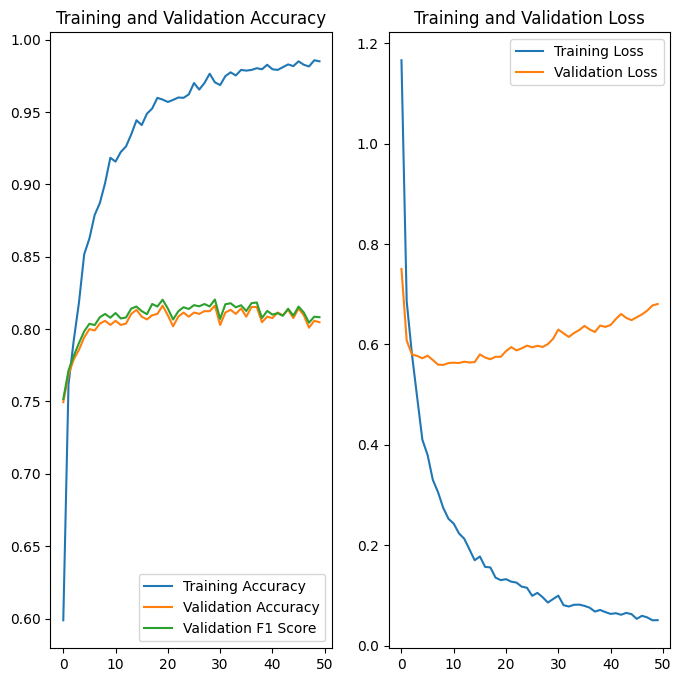

In [30]:
#Accuracy and F1 Scores Plot
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
val_f1 = history.history['val_f1_score']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, val_f1, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Same model as above but with no Macro Averaging for F1 Scores

In [11]:
base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet")
avg=keras.layers.GlobalAvgPool2D()(base_model.output)
norm=keras.layers.BatchNormalization()(avg)
relu=keras.layers.Dense(400,activation="relu")(norm)
norm2=keras.layers.BatchNormalization()(relu)
drop=keras.layers.Dropout(0.2)(norm2)
output=keras.layers.Dense(5,activation="softmax")(drop)
model=keras.Model(inputs=base_model.input,outputs=output)

for layer in base_model.layers:
  layer.trainable=False

optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss="categorical_crossentropy",optimizer=optimizer,
              metrics=["accuracy",tfa.metrics.F1Score(num_classes= 5)])
history = model.fit(train_ds, epochs=50,batch_size=batch_size,validation_data=validation_ds)

Epoch 1/50
132/132 [==============================] - 33s 212ms/step - loss: 1.1269 - accuracy: 0.6019 - f1_score: 0.6010 - val_loss: 0.7318 - val_accuracy: 0.7495 - val_f1_score: 0.7568
Epoch 2/50
132/132 [==============================] - 26s 197ms/step - loss: 0.6912 - accuracy: 0.7552 - f1_score: 0.7595 - val_loss: 0.6031 - val_accuracy: 0.7810 - val_f1_score: 0.7864
Epoch 3/50
132/132 [==============================] - 26s 195ms/step - loss: 0.5701 - accuracy: 0.7952 - f1_score: 0.7986 - val_loss: 0.5969 - val_accuracy: 0.7848 - val_f1_score: 0.7907
Epoch 4/50
132/132 [==============================] - 26s 194ms/step - loss: 0.4698 - accuracy: 0.8281 - f1_score: 0.8317 - val_loss: 0.5957 - val_accuracy: 0.7971 - val_f1_score: 0.8028
Epoch 5/50
132/132 [==============================] - 26s 194ms/step - loss: 0.4042 - accuracy: 0.8490 - f1_score: 0.8531 - val_loss: 0.5956 - val_accuracy: 0.8038 - val_f1_score: 0.8093
Epoch 6/50
132/132 [==============================] - 26s 193ms/s

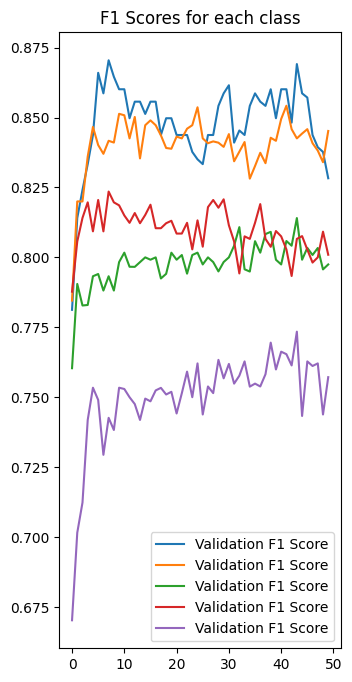

In [14]:
# Plot for individual F1 Scores
val_f1 = history.history['val_f1_score']
epochs_range = range(50)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, val_f1, label='Validation F1 Score')
plt.legend(loc='lower right')
plt.title('F1 Scores for each class')
plt.show()